In [1]:
import os
import glob
import csv

In [15]:
PARENT = "/data/holly_jackson/all-make3d-test-v4"
out_csv = "summary_metrics_all_test_make3d_v4.csv"
# exp_name_format = "coord-descent-aif-init-????_2025-08-20_*"
# exp_name_format = "all-test-????_2025-08-2*"

In [16]:
def parse_last_loss(losses_path):
    # todo: this reads whole file not super efficient
    with open(losses_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip(): # not blank
                last = line.strip()
    return float(last)

def parse_accuracy_metrics(metrics_path):
    rms = rel = d1 = d2 = d3 = None
    with open(metrics_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.lower().startswith("rms"):
                rms = float(line.split(":")[1].strip())
            elif line.lower().startswith("rel"):
                rel = float(line.split(":")[1].strip())
            elif line.lower().startswith("accuracy"):
                right = line.split(":")[1].strip()
                d1, d2, d3 = [float(x.strip()) for x in right.split(",")]
    return (rms, rel, d1, d2, d3)

In [17]:

# pattern = os.path.join(PARENT, exp_name_format)
# dirs = [d for d in glob.glob(pattern) if os.path.isdir(d)]

dirs = [d for d in os.listdir(PARENT) if os.path.isdir(os.path.join(PARENT, d))]

# remove repeats + sort
dirs = sorted(dirs)
print(len(dirs))


133


In [18]:

# depth_dir = "/data/holly_jackson/Make3D/test400Img/"

# # list all training data and extract image number
# files = sorted([
#     f.split("img-")[1].split(".jpg")[0]
#     for f in os.listdir(depth_dir) if f.endswith(".jpg") # f[:-4]
# ])
# print(len(files))

# dirs_filtered = [f.split('make3d-windowed5-thresh0.5-')[1].split('_')[0] for f in dirs]

# missing = list(set(files) - set(dirs_filtered))
# print(missing)

In [19]:
rows = []

for d in dirs:
    # print(d)
    # run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    run_id = os.path.basename(d).split("_")[0].split("thresh0.5-")[1]
    print(run_id)
        
    losses_path = os.path.join(PARENT, d, "losses.txt")
    metrics_path = os.path.join(PARENT, d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue
    
    last_loss = parse_last_loss(losses_path)
    # print(last_loss)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
    # print(rms, rel, d1, d2, d3)

    rows.append({
        "run_id": run_id,
        "last_loss": last_loss,
        "RMS": rms,
        "Rel": rel,
        "delta1": d1,
        "delta2": d2,
        "delta3": d3,
    })


# write to csv all at once
fieldnames = ["run_id", "last_loss", "RMS", "Rel", "delta1", "delta2", "delta3"]
rows.sort(key=lambda r: r["run_id"])

avg_row = {"run_id": "AVERAGE"}
for col in fieldnames[1:]:
    values = [r[col] for r in rows if r[col] is not None]
    avg_row[col] = sum(values) / len(values) if values else None

rows.append(avg_row)

with open(out_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=fieldnames
    )
    writer.writeheader()
    writer.writerows(rows)

print(f"Wrote {len(rows)} rows to {out_csv}")

060705-17.10.14-p-049t000
060705-17.10.14-p-080t000
060705-17.10.14-p-316t000
060705-17.28.10-p-161t000
060705-17.35.48-p-254t000
060705-17.35.48-p-285t000
060705-17.43.27-p-111t000
060705-17.51.18-p-018t000
060705-17.51.18-p-111t000
10.21op2-p-015t000
10.21op2-p-139t000
10.21op2-p-313t000
10.21op3-p-283t000
10.21op6-p-139t000
10.21op6-p-220t000
10.21op6-p-313t000
10.21op9-p-251t000
10.21op9-p-343t000
combined1-p-108t0
combined1-p-170t0
combined1-p-220t0
combined1-p-251t0
gatesback1-p-139t0
gatesback2-p-313t0
gatesback4-p-108t0
gatesback4-p-139t0
manmade5-p-169t0
manmade5-p-313t0
manmade6-p-77t0
math1-p-282t0
math11-p-343t0
math12-p-108t0
math12-p-189t0
math12-p-343t0
math13-p-139t0
math13-p-344t0
math13-p-77t0
math14-p-188t0
math15-p-107t0
math15-p-169t0
math16-p-15t0
math16-p-313t0
math2-p-77t0
math3-p-170t0
math4-p-15t0
math4-p-189t0
math4-p-344t0
math5-p-108t0
math5-p-15t0
math5-p-250t0
math6-p-169t0
math7-p-139t0
math8-p-107t0
math8-p-138t0
math8-p-15t0
math8-p-313t0
math8-p-343t0

In [20]:
import utils 
import numpy as np
import skimage

out_csv = "summary_metrics_all_test_make3d_C1_error_v4.csv"

rows = []

for d in dirs:
    # print(d)
    # run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    run_id = os.path.basename(d).split("_")[0].split("thresh0.5-")[1]
    print(run_id)

    dpt = utils.load_dpt_npy(os.path.join(PARENT, d), 'dpt')

    # compute c1 error 
    _, gt_dpt = utils.load_single_sample_Make3D(img_name = "img-"+run_id+".jpg", data_dir = "/data/holly_jackson/",
                                                split='test')

    gt_dpt_resized = skimage.transform.resize(
        gt_dpt,
        output_shape=(460, 345), # (height, width)
        order=1,                  # bilinear interpolation
        anti_aliasing=True,
        preserve_range=True       # keep values in [0, 255] if original was uint8
    )
    mask = (gt_dpt_resized < 70) & np.isfinite(gt_dpt_resized)
    gt_dpt_masked = gt_dpt_resized[mask]
    dpt_masked = dpt[mask]
    assert np.all(gt_dpt_masked < 70)
    
    rms = utils.compute_RMS(dpt_masked, gt_dpt_masked)
    rel = utils.compute_AbsRel(dpt_masked, gt_dpt_masked)
    # print(rms, rel)
    # break    
    # losses_path = os.path.join(PARENT, d, "losses.txt")
    # metrics_path = os.path.join(PARENT, d, "accuracy_metrics.txt")

    # if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
    #     continue
    
    # last_loss = parse_last_loss(losses_path)
    # print(last_loss)
    # rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
    # print(rms, rel, d1, d2, d3)

    rows.append({
        "run_id": run_id,
        # "last_loss": last_loss,
        "RMS": rms,
        "Rel": rel,
        # "delta1": d1,
        # "delta2": d2,
        # "delta3": d3,
    })



060705-17.10.14-p-049t000
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 4.32 - 80.0
060705-17.10.14-p-080t000
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 4.3 - 80.0
060705-17.10.14-p-316t000
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 3.78 - 80.0
060705-17.28.10-p-161t000
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 2.21 - 80.0
060705-17.35.48-p-254t000
Camera: Canon Canon PowerShot S40
Focal len

In [21]:

# write to csv all at once
fieldnames = ["run_id", "RMS", "Rel"]
rows.sort(key=lambda r: r["run_id"])

avg_row = {"run_id": "AVERAGE"}
for col in fieldnames[1:]:
    values = [r[col] for r in rows if r[col] is not None]
    avg_row[col] = sum(values) / len(values) if values else None

rows.append(avg_row)

with open(out_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=fieldnames
    )
    writer.writeheader()
    writer.writerows(rows)

print(f"Wrote {len(rows)} rows to {out_csv}")

Wrote 134 rows to summary_metrics_all_test_make3d_C1_error_v4.csv


Df: [ 1.  2.  4.  8. 16. 32. 64.]
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 3.3600285 - 81.921196


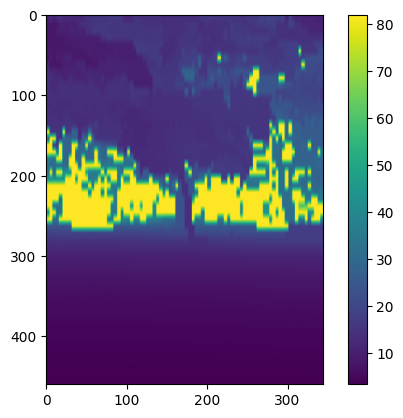

adaptive kernel size set to 17


In [22]:
import utils 
import forward_model
import globals
import skimage
import matplotlib.pyplot as plt

globals.init_Make3D()

globals.thresh = 0.5
IMAGE_RANGE = 255.

gt_aif, gt_dpt = utils.load_single_sample_Make3D(data_dir = "/data/holly_jackson/")
gt_aif = gt_aif * IMAGE_RANGE

gt_dpt_resized = skimage.transform.resize(
    gt_dpt,
    output_shape=(460, 345), # (height, width)
    order=1,                  # bilinear interpolation
    anti_aliasing=True,
    preserve_range=True       # keep values in [0, 255] if original was uint8
)

plt.imshow(gt_dpt_resized)
plt.colorbar()
plt.show()

width, height, _ = gt_aif.shape
max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)



In [23]:
import matplotlib.pyplot as plt
import section_search
import utils
import math

count = 0

worst_rms = 0
worst_file = None
best_rms = float('inf')
best_file = None

for d in dirs:

    run_id = os.path.basename(d).split("_")[0].split("thresh0.5-")[1]
        
    losses_path = os.path.join(PARENT, d, "losses.txt")
    metrics_path = os.path.join(PARENT, d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue

    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)

    if rms > worst_rms:
        worst_rms = rms
        worst_file = d
    if rms < best_rms:
        best_rms = rms
        best_file = d

    print('mse:',last_loss, ', rms:', rms)
    
    count += 1
    


mse: 0.17297178506851196 , rms: 10.539369
mse: 0.1752844899892807 , rms: 9.139575
mse: 0.2948492765426636 , rms: 1.577809
mse: 0.09317933768033981 , rms: 7.619593
mse: 0.140041783452034 , rms: 7.619324
mse: 0.1288728415966034 , rms: 14.676478
mse: 0.4610167145729065 , rms: 7.348082
mse: 0.12993304431438446 , rms: 2.822385
mse: 0.3893444240093231 , rms: 6.39304
mse: 0.18184073269367218 , rms: 5.122056
mse: 0.03153972700238228 , rms: 0.324034
mse: 0.03648776188492775 , rms: 1.375435
mse: 0.33643558621406555 , rms: 1.257572
mse: 0.26479315757751465 , rms: 1.454797
mse: 2.800734519958496 , rms: 3.370652
mse: 1.58062744140625 , rms: 8.974487
mse: 0.057868361473083496 , rms: 0.712344
mse: 0.1360168606042862 , rms: 10.246976
mse: 0.12377601861953735 , rms: 4.06774
mse: 0.3675229549407959 , rms: 13.929398
mse: 0.24531243741512299 , rms: 7.845687
mse: 0.1561458855867386 , rms: 9.335159
mse: 0.30761030316352844 , rms: 14.358037
mse: 0.5869843363761902 , rms: 4.654434
mse: 0.17278675734996796 , r

In [24]:
# import utils
# import os
# import coordinate_descent
# d = best_file

# dpt_test = utils.load_dpt_npy(os.path.join(PARENT, d), "dpt")
# aif_test = utils.load_aif(os.path.join(PARENT, d), "aif")

# run_id = os.path.basename(d).split("_")[0].split("thresh0.5-")[1]

# losses_path = os.path.join(PARENT, d, "losses.txt")
# metrics_path = os.path.join(PARENT, d, "accuracy_metrics.txt")

# last_loss = parse_last_loss(losses_path)
# rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
# print(last_loss, rms, rel)

# defocus_stack_test = forward_model.forward(dpt_test, aif_test)

# gt_aif, gt_dpt = utils.load_single_sample_Make3D(img_name='img-'+run_id+'.jpg')
# gt_aif = gt_aif * IMAGE_RANGE
# gt_dpt_resized = skimage.transform.resize(
#     gt_dpt,
#     output_shape=(460, 345), # (height, width)
#     order=1,                  # bilinear interpolation
#     anti_aliasing=True,
#     preserve_range=True       # keep values in [0, 255] if original was uint8
# )

# utils.plot_compare_greyscale(dpt_test, gt_dpt_resized, vmin=gt_dpt.min(), vmax=gt_dpt.max())
# plt.show()

# # # TODO: need to fix this code but after entire set runs 
# dpt_no_outliers, _ = section_search.remove_outliers(
#     dpt_test, aif_test, diff_thresh = 2, tv_thresh = 0.4, patch_type = 'tv')

# defocus_stack_test_no_outliers = forward_model.forward(dpt_no_outliers, aif_test)

# utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt_resized, vmin=gt_dpt.min(), vmax=gt_dpt.max())
# plt.show()
# print('new RMS', utils.compute_RMS(dpt_no_outliers, gt_dpt_resized))
# # print('new MSE', coordinate_descent.mse_loss(
#     # defocus_stack_test_no_outliers, defocus_stack))

# utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
# plt.show()


# plt.imsave(
#     "figures/Make3D_recon_AIF_best_RMS_train.png",
#     aif_test / IMAGE_RANGE,
#     origin="upper",
# )

# plt.imsave(
#     "figures/Make3D_gt_AIF_best_RMS_train.png",
#     gt_aif / IMAGE_RANGE,
#     origin="upper",
# )

# plt.imsave(
#     "figures/Make3D_recon_DPT_best_RMS_train.png",
#     dpt_test,
#     cmap="viridis",
#     vmin=globals.min_Z, vmax=globals.max_Z,
#     origin="upper",
# )

# plt.imsave(
#     "figures/Make3D_recon_DPT_NOOUTLIER_TVTHRESH_4e-1_best_RMS_train.png",
#     dpt_no_outliers,
#     cmap="viridis",
#     vmin=globals.min_Z, vmax=globals.max_Z,
#     origin="upper",
# )

# plt.imsave(
#     "figures/Make3D_gt_DPT_best_RMS_train.png",
#     gt_dpt_resized,
#     cmap="viridis",
#     vmin=globals.min_Z, vmax=globals.max_Z,
#     origin="upper",
# )

Df: [ 1.  2.  4.  8. 16. 32. 64.]
['make3d-windowed5-thresh0.5-060705-17.51.18-p-111t000_2025-11-11_23-54-50', 'make3d-windowed5-thresh0.5-op10-p-108t000_2025-11-12_02-02-36', 'make3d-windowed5-thresh0.5-stats6-p-107t0_2025-11-12_06-00-54', 'make3d-windowed5-thresh0.5-op36-p-251t000_2025-11-12_04-02-40']
0.3893444240093231 6.39304 0.038589
precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 4.18 - 80.0


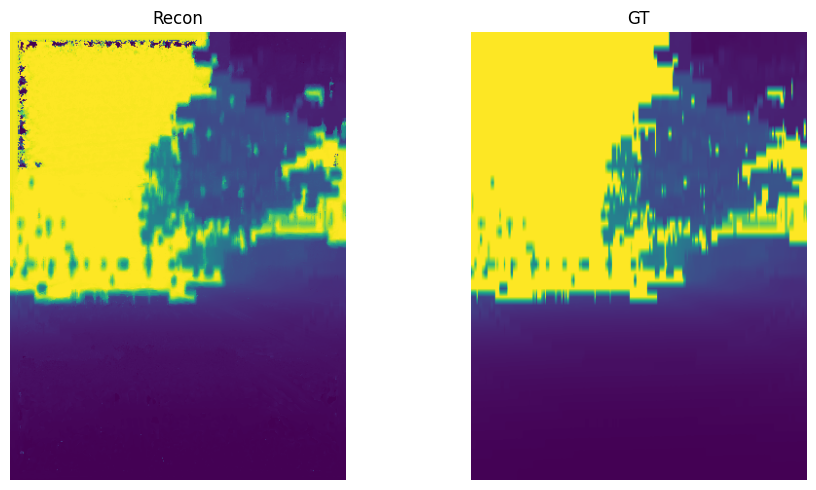

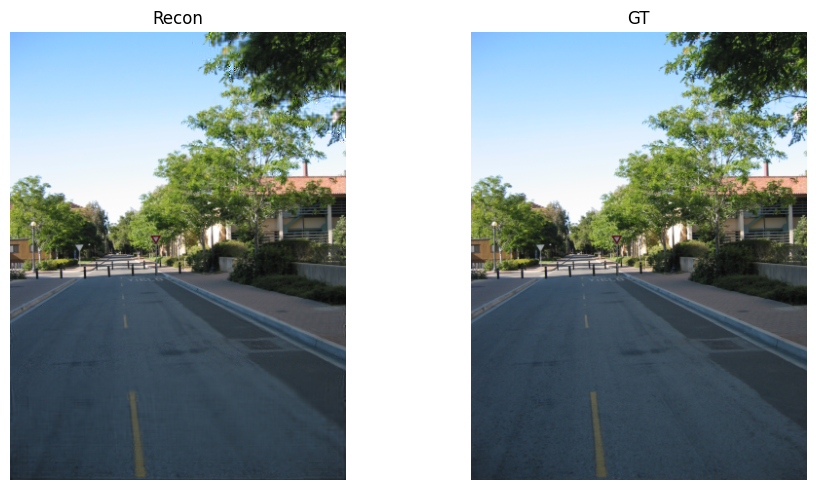

0.03321417421102524 0.24328 0.013892
precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 4.5
Aperture diameter (m): 0.001576388888888889
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 3.93 - 17.69


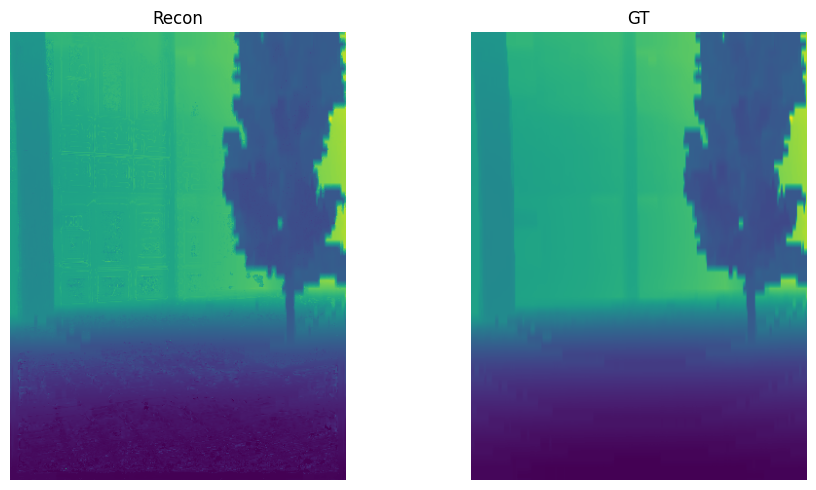

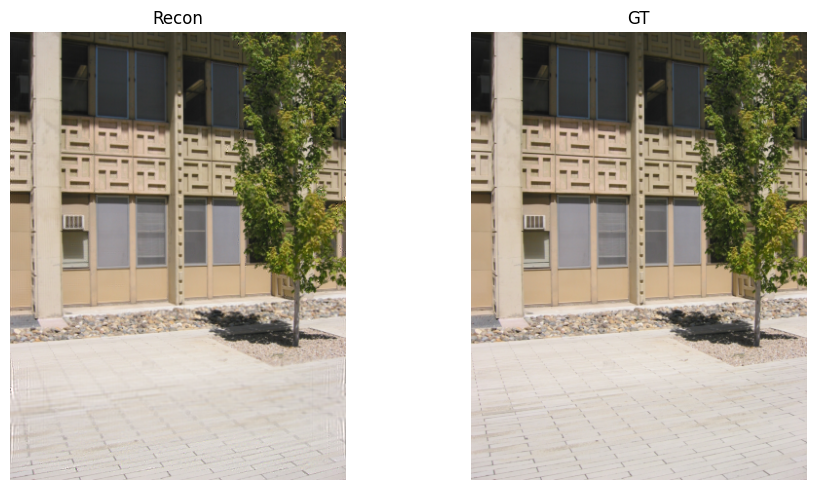

1.3462049961090088 3.370724 0.192241
precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 0.95745295 - 81.92103


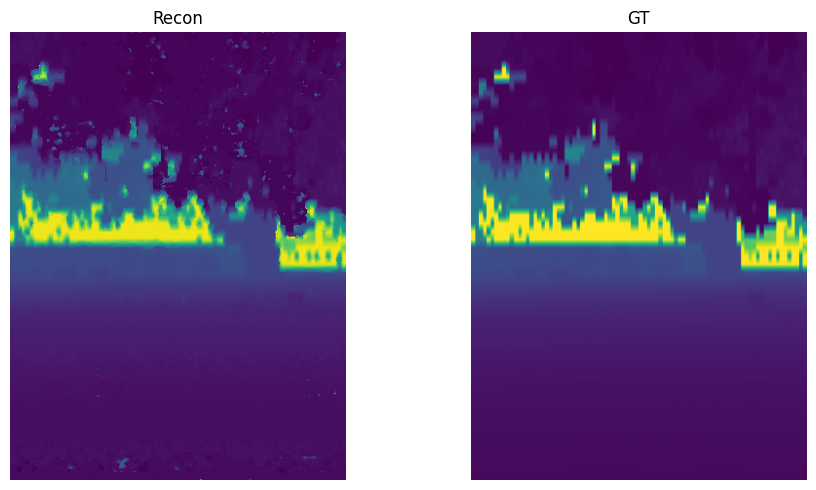

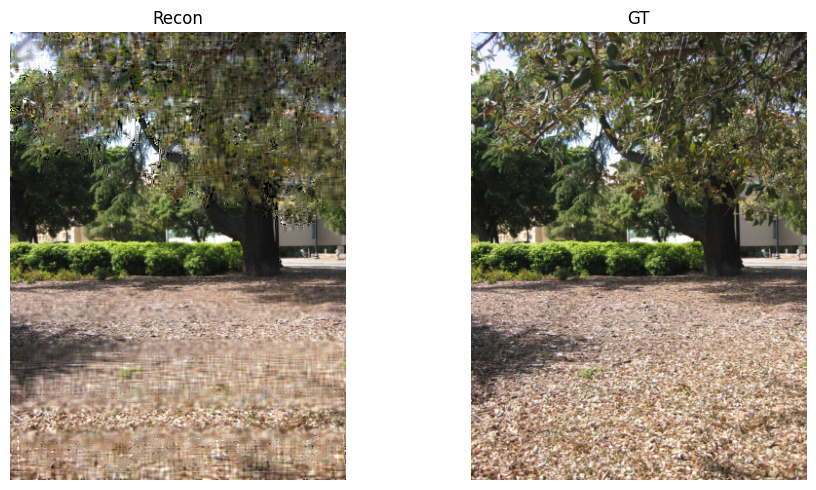

1.0500625371932983 6.401613 0.07767
precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 3.84 - 80.0


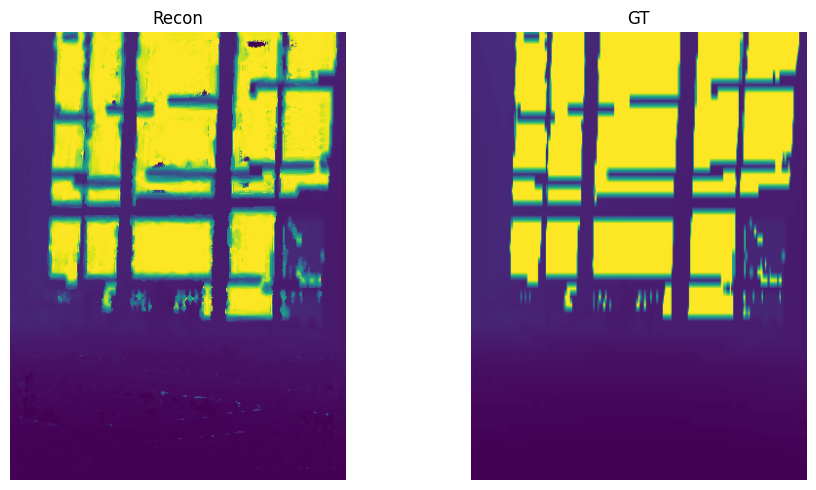

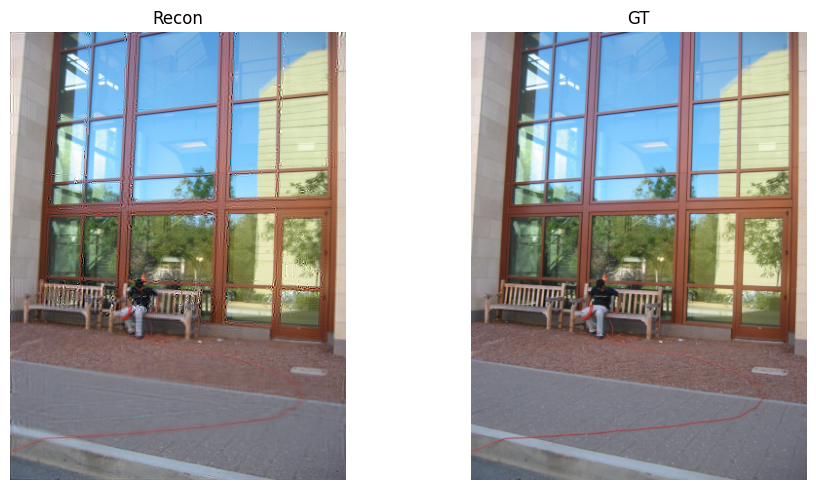

In [25]:
globals.init_Make3D()
globals.window_size = 5
globals.thresh = 0.5
import least_squares


import random
# Choose 4 random examples to save
examples = random.sample(dirs, 4)
print(examples)
for i in range(len(examples)):
    d = examples[i]

    dpt_test = utils.load_dpt_npy(os.path.join(PARENT, d), "dpt")
    aif_test = utils.load_aif(os.path.join(PARENT, d), "aif")
    
    run_id = os.path.basename(d).split("_")[0].split("thresh0.5-")[1]
    
    losses_path = os.path.join(PARENT, d, "losses.txt")
    metrics_path = os.path.join(PARENT, d, "accuracy_metrics.txt")
    
    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
    print(last_loss, rms, rel)
    
    defocus_stack_test = forward_model.forward(dpt_test, aif_test)
    
    gt_aif, gt_dpt = utils.load_single_sample_Make3D(img_name='img-'+run_id+'.jpg', split='test')
    gt_aif = gt_aif * IMAGE_RANGE
    gt_dpt_resized = skimage.transform.resize(
        gt_dpt,
        output_shape=(460, 345), # (height, width)
        order=1,                  # bilinear interpolation
        anti_aliasing=True,
        preserve_range=True       # keep values in [0, 255] if original was uint8
    )
    # globals.ps *= 0.01 # scaling factor on ps 
    # defocus_stack = forward_model.forward(gt_dpt_resized, gt_aif)

    # # run one more fista 
    # aif_test_v2 = least_squares.bounded_fista_3d(dpt_test, defocus_stack, 255, maxiter=200, verbose=True)
    
    utils.plot_compare_greyscale(dpt_test, gt_dpt_resized, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    plt.show()
    
    # # # TODO: need to fix this code but after entire set runs 
    # dpt_no_outliers, _ = section_search.remove_outliers(
    #     dpt_test, aif_test, diff_thresh = 2, tv_thresh = 1, patch_type = 'tv')
    
    # defocus_stack_test_no_outliers = forward_model.forward(dpt_no_outliers, aif_test)
    
    # utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt_resized, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    # plt.show()
    # print('new RMS', utils.compute_RMS(dpt_no_outliers, gt_dpt_resized))
    # print('new AbsRel', utils.compute_AbsRel(dpt_no_outliers, gt_dpt_resized))
    # print('new MSE', coordinate_descent.mse_loss(
        # defocus_stack_test_no_outliers, defocus_stack))
    
    utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
    plt.show()

    # utils.plot_compare_greyscale(aif_test_v2 / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
    # plt.show()
    
    # save everything for figures
    
    plt.imsave(
        "figures/Make3D_recon_AIF_example"+str(i)+"_test.png",
        aif_test / IMAGE_RANGE,
        origin="upper",
    )

    # plt.imsave(
    #     "figures/Make3D_recon_AIF_v2_example"+str(i)+"_test.png",
    #     aif_test_v2 / IMAGE_RANGE,
    #     origin="upper",
    # )
    
    plt.imsave(
        "figures/Make3D_gt_AIF_example"+str(i)+"_test.png",
        gt_aif / IMAGE_RANGE,
        origin="upper",
    )
    
    plt.imsave(
        "figures/Make3D_recon_DPT_example"+str(i)+"_test.png",
        dpt_test,
        cmap="viridis",
        vmin=gt_dpt.min(), vmax=gt_dpt.max(),
        origin="upper",
    )
    
    plt.imsave(
        "figures/Make3D_gt_DPT_example"+str(i)+"_test.png",
        gt_dpt_resized,
        cmap="viridis",
        vmin=gt_dpt.min(), vmax=gt_dpt.max(),
        origin="upper",
    )

In [19]:
import matplotlib.pyplot as plt
import section_search
import utils
import math


count = 0
worst_rms = 0
worst_file = None
best_rms = 0
best_file = None

for d in dirs:

    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("thresh0.5-")[1]
    # print(run_id)
        
    losses_path = os.path.join(PARENT, d, "losses.txt")
    metrics_path = os.path.join(PARENT, d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue

    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)


    dpt_test = utils.load_dpt_npy(os.path.join(PARENT, d), "dpt")
    aif_test = utils.load_aif(os.path.join(PARENT, d), "aif")
    
    defocus_stack_test = forward_model.forward(dpt_test, aif_test)

    gt_aif, gt_dpt = utils.load_single_sample_Make3D(img_name='img-'+run_id+'.jpg')
    gt_aif = gt_aif * IMAGE_RANGE
    gt_dpt_resized = skimage.transform.resize(
        gt_dpt,
        output_shape=(460, 345), # (height, width)
        order=1,                  # bilinear interpolation
        anti_aliasing=True,
        preserve_range=True       # keep values in [0, 255] if original was uint8
    )


    absrel = utils.compute_AbsRel(dpt_test, gt_dpt_resized)
    print(rel, absrel)
    assert math.isclose(absrel, rel, rel_tol=1e-5, abs_tol=1e-5)

    recon_rms = utils.compute_RMS(dpt_test, gt_dpt_resized)
    print(rel, absrel)
    assert math.isclose(recon_rms, rms, rel_tol=1e-5, abs_tol=1e-5)

    

    # print('mse:',last_loss, ', rms:', rms)
    
    count += 1
    


precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 3.2
Aperture diameter (m): 0.002216796875
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 4.08 - 80.0
2.214964 2.2149644
2.214964 2.2149644
precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 3.2
Aperture diameter (m): 0.002216796875
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 4.12 - 80.0
2.234306 2.2343063
2.234306 2.2343063
precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range: 3.94 - 80.0
0.066587 0.06658719
0.066587 0.06658719
precomputing indices
Camera: Canon Canon PowerShot S40
Focal length (m): 0.00709375
F-number: 2.8
Aperture diameter (m): 0.0025334821428571433
(2272, 1704, 3)
Pixel size (m/pix): 1.5456521739130434e-05
GT DPT Range


KeyboardInterrupt

